In [1]:
import subprocess 
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas
import seaborn as sns
import itertools
import random
import math

## Generación de prueba

In [2]:
input_path = "../datos_entrada/ej2/"

In [3]:
def combinacionValida(n,ejes):
    for i in range(n,1,-1):
        if len([(x,y) for x,y in ejes if y == i or x == i]) == 0:
            return False
    return True
        

In [4]:
repeticiones=10
tamanios=range(2,11)
files = []
for n in tamanios:
    ejes_posibles = list(itertools.combinations(range(1,n+1),2))
    
    #>= 90% de ejes usados
    m = random.randint(int(len(ejes_posibles)*0.9),len(ejes_posibles))
    
    random.shuffle(ejes_posibles)
    while not combinacionValida(n,ejes_posibles[0:m]):
        m = m + 1
    ejes = ejes_posibles[0:m]
    
    file = {
        "n": n,
        "m": m,
        "name": f"exp_random_denso_{n}nodos_{m}ejes.txt",
        "absPath": os.path.abspath(f"{input_path}/exp_random_denso_{n}nodos_{m}ejes.txt")
    }
    
    f = open(file["absPath"], "w")
    f.write(f"{n} {m}\n")
    for i in range(0,n):
        costo = random.randint(1,100)
        f.write(f"{costo}\n")
    for (src,dest) in ejes:
        distancia = random.randint(1,100)
        f.write(f"{src} {dest} {distancia}\n")
    f.close()
    
    files.append(file)

In [5]:
def run(file,metodo):
    
    completado = subprocess.run(["../../Resolucion/bin/ej2",file["absPath"],str(metodo)], stdout=subprocess.PIPE, universal_newlines=True)
    if completado.returncode != 0:
        return "ERROR: El programa finalizo de forma incorrecta. Parametros usados: k={0} metodo={1}".format(k,metodo)
    else:
        return completado.stdout

resultFile = f"{input_path}/results.txt"
tiempos = "./ej2_denso.csv"
f = open(resultFile,"a+")
for file in files:
    for i in range(1,repeticiones):
        if(file["n"] < 5):
            f.write(run(file,0)) #Dijkstra Arreglo
        f.write(run(file,1)) #Dijkstra Cola
        f.write(run(file,2)) #BellmanFord
        f.write(run(file,3)) #FloydWarshall    
    
f.close()

In [10]:
csv = pandas.read_csv(tiempos)

/home/ezequiel/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ezequiel/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


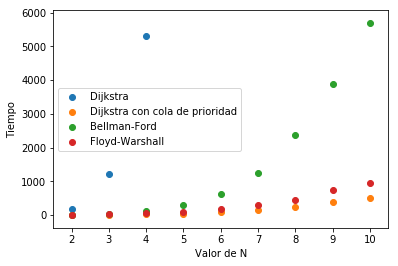

In [11]:
plt.clf()
for method in csv["Metodo"].unique():
    csvOnlyNames = csv.dropna(subset=['Filename'])
    methodResults = csvOnlyNames[csvOnlyNames["Metodo"]==method]
    resultsByN = [np.median(methodResults[methodResults["n"] == n]["Tiempo"]) for n in tamanios]
    plt.scatter(tamanios,resultsByN,label=method)


plt.legend();
plt.xlabel("Valor de N")
plt.ylabel("Tiempo");


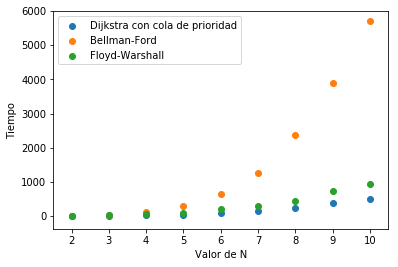

In [12]:
plt.clf()
for method in csv["Metodo"].unique():
    if method != "Dijkstra":
        csvOnlyNames = csv.dropna(subset=['Filename'])
        methodResults = csvOnlyNames[csvOnlyNames["Metodo"]==method]
        resultsByN = [np.median(methodResults[methodResults["n"] == n]["Tiempo"]) for n in tamanios]
        plt.scatter(tamanios,resultsByN,label=method)

plt.legend();
plt.xlabel("Valor de N")
plt.ylabel("Tiempo");

### Corelación entre tiempo de ejecución y cota de algortimo para cada una de estructuras

In [13]:
csv["nodosEnH"] = csv["n"] * 60
csv["logNodosEnH"] = np.log(csv["nodosEnH"])

csv["cotaDijkstra-Arreglo"] = csv["n"] * csv["nodosEnH"]**3
csv["cotaDijkstra-Cola"] = csv["n"] * csv["nodosEnH"]**2 * csv["logNodosEnH"]
csv["cotaFloyd"] = csv["n"] * csv["nodosEnH"]**2
csv["cotaBellman"] = csv["n"] * csv["nodosEnH"]**3

csvDijkstraArreglo = csv[csv["Metodo"]=="Dijkstra"]
csvDijkstraCola = csv[csv["Metodo"]=="Dijkstra con cola de prioridad"]
csvFloyd = csv[csv["Metodo"]=="Floyd-Warshall"]
csvBellman = csv[csv["Metodo"]=="Bellman-Ford"]

c_dijkstraArreglo = np.corrcoef(csvDijkstraArreglo["Tiempo"], csvDijkstraArreglo["cotaDijkstra-Arreglo"])[0, 1]
c_dijkstraCola = np.corrcoef(csvDijkstraCola["Tiempo"], csvDijkstraCola["cotaDijkstra-Cola"])[0, 1]
c_floyd = np.corrcoef(csvFloyd["Tiempo"], csvFloyd["cotaFloyd"])[0, 1]
c_bellman = np.corrcoef(csvBellman["Tiempo"], csvBellman["cotaBellman"])[0, 1]

print("Las cotas calculadas son para la obtención de los caminos de TODAS las ciudades, contemplando que el grafo sobre el cual se aplica el algoritmo tiene 60 veces la cantidad de nodos que el original")
print(f"El coeficiente de correlación de Pearson para Dijkstra con arreglo contra O(n^4) es: {c_dijkstraArreglo}")
print(f"El coeficiente de correlación de Pearson para Dijkstra con cola contra O(n^3*log(n)) es: {c_dijkstraCola}")
print(f"El coeficiente de correlación de Pearson para Floyd con contra O(n^3) es: {c_floyd}")
print(f"El coeficiente de correlación de Pearson para Bellman con contra O(n^3) es: {c_bellman}")

Las cotas calculadas son para la obtención de los caminos de TODAS las ciudades, contemplando que el grafo sobre el cual se aplica el algoritmo tiene 60 veces la cantidad de nodos que el original
El coeficiente de correlación de Pearson para Dijkstra con arreglo contra O(n^4) es: 0.9948158460577858
El coeficiente de correlación de Pearson para Dijkstra con cola contra O(n^3*log(n)) es: 0.9903601632988249
El coeficiente de correlación de Pearson para Floyd con contra O(n^3) es: 0.9892283736702207
El coeficiente de correlación de Pearson para Bellman con contra O(n^3) es: 0.9948015319587127
